In [ ]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import seaborn as sns
from matplotlib import pyplot as plt
import h5py
import io
from PIL import Image



In [ ]:
dir = "isic-2024-challenge"
train_df = pd.read_csv(f"{dir}/train-metadata.csv")
train_img = f"{dir}/train-image/image"
train_hdf5 = f"{dir}/train-image.hdf5"


FileNotFoundError: [Errno 2] No such file or directory: 'train-metadata.csv'

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,401059.0,0.000980,0.031288,0.000000e+00,0.000000,0.000000,0.000000,1.000000
age_approx,398261.0,58.012986,13.596165,5.000000e+00,50.000000,60.000000,70.000000,85.000000
clin_size_long_diam_mm,401059.0,3.930827,1.743068,1.000000e+00,2.840000,3.370000,4.380000,28.400000
tbp_lv_A,401059.0,19.974007,3.999489,-2.487115e+00,17.330821,19.801910,22.304628,48.189610
tbp_lv_Aext,401059.0,14.919247,3.529384,-9.080269e+00,12.469740,14.713930,17.137175,37.021680
tbp_lv_B,401059.0,28.281706,5.278676,-7.309895e-01,24.704372,28.171570,31.637429,54.306900
tbp_lv_Bext,401059.0,26.913015,4.482994,9.237066e+00,23.848125,26.701704,29.679913,48.372700
tbp_lv_C,401059.0,34.786341,5.708469,3.054228e+00,31.003148,34.822580,38.430298,58.765170
tbp_lv_Cext,401059.0,30.921279,4.829345,1.184652e+01,27.658285,30.804893,33.963868,54.305290
tbp_lv_H,401059.0,54.653689,5.520849,-1.574164e+00,51.566273,55.035632,58.298184,105.875784


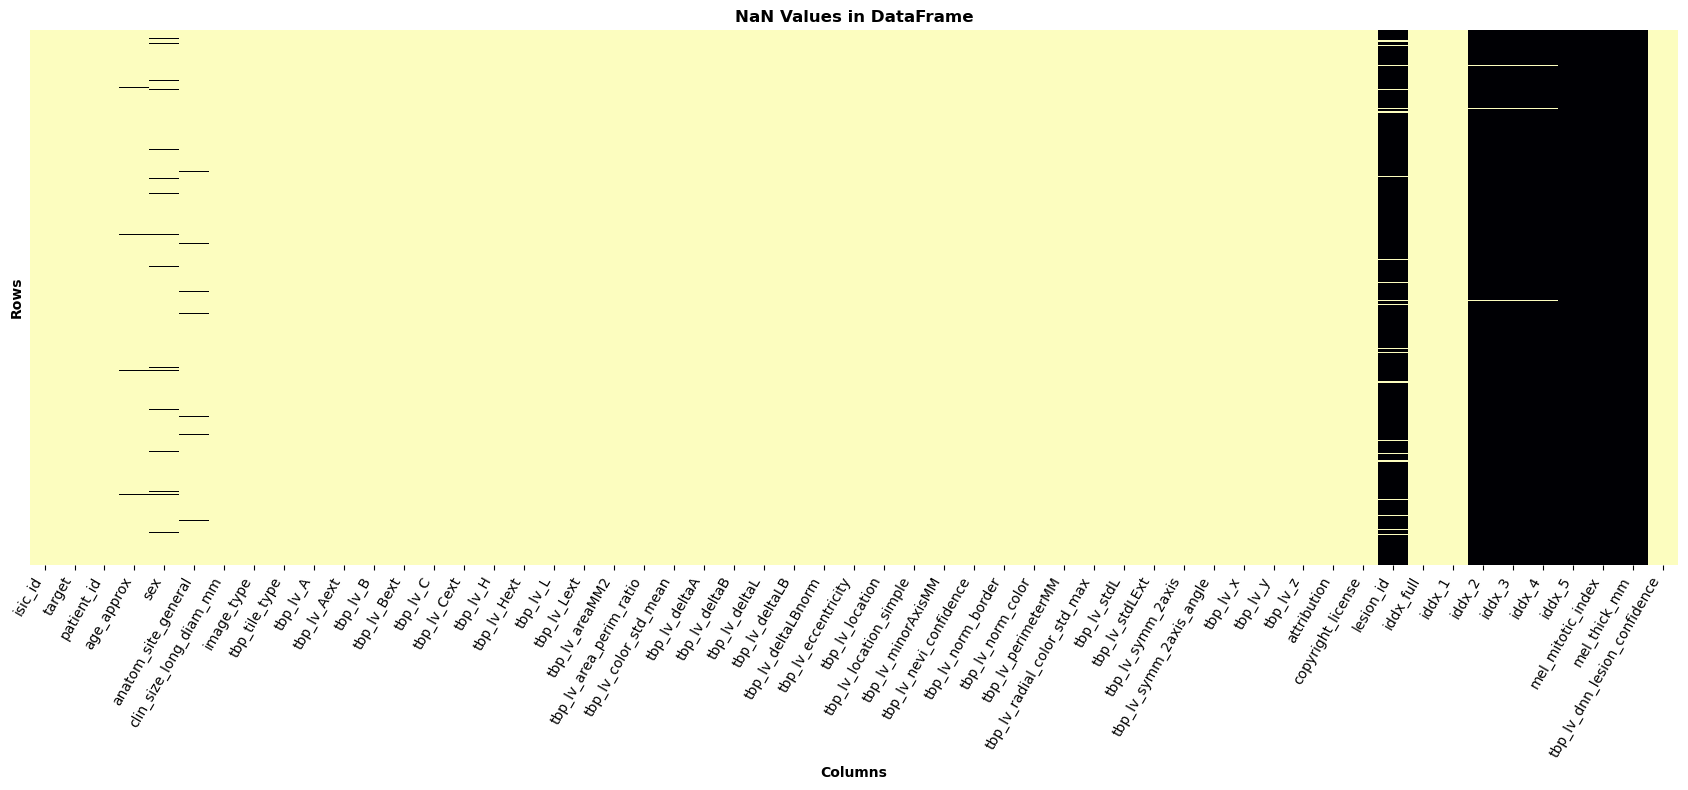

NaN counts per column:


/var/folders/3_/vryb3cvs6cjffdgbdr66z8dw0000gn/T/ipykernel_1426/3472028999.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(nan_counts[nan_counts])


IndexError: positional indexers are out-of-bounds

In [ ]:
def plot_nan_heatmap(
    df: pd.DataFrame, 
    figsize: tuple = (17, 8), 
    cmap: str = 'magma_r', 
    title: str = 'NaN Values in DataFrame',
    x_tick_rotation=60,
    show_cbar: bool = False, 
    show_yticklabels: bool = False
) -> None:
    """Create a heatmap to visualize NaN values in a DataFrame.

    Args:
        df (pd.DataFrame): 
            The input DataFrame to visualize.
        figsize (tuple[int], optional): 
            Figure size as a tuple of (width, height)
        cmap (str, optional): 
            Colormap to use for the heatmap
        title (str, optional): 
            Title for the heatmap.
        x_tick_rotation (int, optional): 
        Rotation angle for x-axis tick labels.
        show_cbar (bool, optional): 
            Whether to show the color bar.
        show_yticklabels (bool, optional): 
            Whether to show y-axis tick labels.

    Returns:
        None; 
            The function displays the plot using plt.show().
    """
    
    # Setup the figure
    plt.figure(figsize=figsize)
    # Create the heatmap
    sns.heatmap(df.isna(), cbar=show_cbar, yticklabels=show_yticklabels, cmap=cmap)
    
    # Update the title/labels
    plt.title(title, fontweight="bold")
    plt.xlabel('Columns', fontweight="bold")
    plt.ylabel('Rows', fontweight="bold")
    
    
    # Rotate x-axis labels
    plt.xticks(rotation=x_tick_rotation, ha='right')
    
    # Adjust the bottom margin to prevent label cutoff
    plt.tight_layout()
    
    # Render
    plt.show()
     # Print NaN counts per column
    nan_counts = df.isna().sum().sort_values(ascending=False)
    
    # clr_print()
    print("NaN counts per column:")
    print(nan_counts[nan_counts])
    print("Features with 0 NaN values:")
    
plot_nan_heatmap(train_df)

In [ ]:
def plot_target_log_distribution(df, target_column='target'):
    """
    Plots the distribution (bar chart) of a categorical target variable on a log scale.
    
    Parameters:
      - df: pandas DataFrame that contains the target column.
      - target_column: name of the column in df that holds the categorical target (default is 'target').
    
    The function computes the count of each category and then displays a bar chart with 
    the y-axis scaled logarithmically.
    """
    # Compute frequency counts for each category
    counts = df[target_column].value_counts()
    
    # Create the bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')
    plt.yscale('log')  # Set the y-axis to log scale
    
    # Add labels and title
    plt.xlabel("Category")
    plt.ylabel("Count (log scale)")
    plt.title(f'Distribution of "{target_column}" on a Log Scale')
    
    # Optionally add the count above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_target_log_distribution(train_df)

In [ ]:
def plot_anatom_site_target_distribution(df):
    """
    Plots the bar chart distribution of target values for each entry in the
    'anatom_site_general' column from the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input dataframe. Must include 'anatom_site_general' and 'target' columns.
    """
    # Verify required columns exist
    required_columns = ['anatom_site_general', 'target']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"The DataFrame must include a '{col}' column.")
    
    # Group by 'anatom_site_general' and 'target', count occurrences and reshape
    grouped = df.groupby(['anatom_site_general', 'target']).size().unstack(fill_value=0)
    
    # Plot the grouped data as a stacked bar chart
    plt.figure(figsize=(10, 6))
    grouped.plot(kind='bar', stacked=True)
    plt.title("Distribution of Target by Anatom Site General")
    plt.xlabel("Anatom Site General")
    plt.ylabel("Count")
    plt.legend(title="Target")
    plt.tight_layout()
    plt.show()

plot_anatom_site_target_distribution(train_df)

In [ ]:
def plot_sex_target_distribution(df):
    """
    Plots the bar chart distribution of target values for each entry in the
    'sex' column from the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input dataframe. Must include 'sex' and 'target' columns.
    """
    # Verify that required columns exist
    for col in ['sex', 'target']:
        if col not in df.columns:
            raise ValueError(f"The DataFrame must include a '{col}' column.")
    
    # Group by 'sex' and 'target', count occurrences, and reshape the data
    grouped = df.groupby(['sex', 'target']).size().unstack(fill_value=0)
    
    # Plot the grouped data as a stacked bar chart
    plt.figure(figsize=(8, 6))
    grouped.plot(kind='bar', stacked=True)
    plt.title("Distribution of Target by Sex")
    plt.xlabel("Sex")
    plt.ylabel("Count")
    plt.legend(title="Target")
    plt.tight_layout()
    plt.show()

plot_sex_target_distribution(train_df)

In [ ]:
def plot_clinical_size_vs_area_perimeter_ratio(
    df,
    x_col='Area-to-Perimeter Ratio',
    y_col='Clinical Size (Longest Diameter in mm)',
    color_col='anatom_site_general'
):
    """
    Creates an interactive scatter plot showing the relationship between two numeric
    columns (x_col and y_col), with points colored by a categorical variable (color_col).

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing your data.
    x_col : str
        The name of the column to use for the x-axis values.
    y_col : str
        The name of the column to use for the y-axis values.
    color_col : str
        The name of the column to use for coloring the points (typically a categorical feature).

    Returns
    -------
    fig : plotly.graph_objs._figure.Figure
        The Plotly figure object that you can display with fig.show().
    """
    # Basic validation
    for col in [x_col, y_col, color_col]:
        if col not in df.columns:
            raise ValueError(f"DataFrame must include '{col}' column.")

    # Create the scatter plot
    fig = px.scatter(
        df,
        x=x_col,
        y=y_col,
        color=color_col,
        size_max=15,        # Maximum size of markers
        opacity=0.8,        # Adjust marker transparency (0=transparent, 1=opaque)
        hover_data=df.columns,  # Show additional columns in the hover tooltip if desired
    )

    # Customize layout
    fig.update_layout(
        title=f"Scatter Plot: '{y_col}' vs '{x_col}'",
        xaxis_title=x_col,
        yaxis_title=y_col,
        legend_title=color_col
    )
    
    # Customize axes (optional: e.g., set range or formatting)
    # fig.update_xaxes(range=[0, 60])  # example range for x-axis
    # fig.update_yaxes(range=[0, 20])  # example range for y-axis

    return fig

fig = plot_clinical_size_vs_area_perimeter_ratio(train_df)
fig.show()

In [ ]:
def plot_target_correlations(df, target='target'):
    """
    Computes and plots the correlation of numeric features with the target variable.
    
    This function performs the following:
      - Selects only numeric columns from the DataFrame.
      - Computes the correlation matrix of these columns.
      - Extracts the correlation of each feature with the target.
      - Creates a horizontal bar chart of these correlations.
      - Plots the full correlation matrix as a heatmap.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing your data.
        target (str): The name of the target column (must be numeric).
    """
    
    # Ensure the target column exists
    if target not in df.columns:
        raise ValueError(f"The DataFrame must include a '{target}' column.")
    
    # Select numeric features
    numeric_df = df.select_dtypes(include=['number'])
    
    # Ensure that target is numeric for correlation
    if target not in numeric_df.columns:
        raise ValueError("Target column is not numeric; cannot compute correlation.")

    # Compute the correlation matrix
    corr_matrix = numeric_df.corr()

    # Extract correlations with the target column (dropping target itself)
    target_corr = corr_matrix[target].drop(labels=[target])
    
    # Option 1: Horizontal Bar Chart of correlations with the target
    plt.figure(figsize=(8, 6))
    target_corr.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Correlation of Numeric Features with '{target}'")
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Features")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Option 2: Full Correlation Matrix Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.tight_layout()
    plt.show()

plot_target_correlations(train_df)

In [ ]:
def load_img_from_hdf5(
    isic_id: str, 
    file_path: str = train_hdf5, 
    n_channels: int = 3
):
    """
    Load an image from the HDF5 dataset file by specifying an ISIC ID.
    
    The ISIC ID is expected to be in the form 'ISIC_#######'.
    
    Args:
        isic_id (str): The ID of the image to load.
        file_path (str): The path to the HDF5 file.
        n_channels (int): Number of channels (3 for RGB, 1 for grayscale).
    
    Returns:
        np.ndarray: The loaded image.
    
    Raises:
        KeyError: If the ISIC ID is not found in the HDF5 file.
        ValueError: If the image data cannot be decoded.
    
    Example Usage:
        img = load_img_from_hdf5('ISIC_0000000')
    """
     # Handle the case where the isic_id is passed incorrectly
    if not isic_id.lower().startswith("isic"):
        isic_id = f"ISIC_{int(str(isic_id).split('_', 1)[-1]):>07}"
        
    # Open the HDF5 file in read mode
    with h5py.File(file_path, 'r') as hf:
        
        # Retrieve the image data from the HDF5 dataset using the provided ISIC ID
        try:
            image_data = hf[isic_id][()]
        except KeyError:
            raise KeyError(f"ISIC ID {isic_id} not found in HDF5 file.")

        # Convert the binary data to a numpy array
    plt.figure(figsize=(6,6))
    plt.title("ISIC_0015670", fontweight="bold")
    plt.imshow(load_img_from_hdf5("ISIC_0015670"))
    plt.show()

In [ ]:
def decode_isic_image(isic_id, file_path, num_channels=3, as_array=False):
    """
    Decodes an ISIC image from an HDF5 file.

    The HDF5 file is expected to store images with keys corresponding to their ISIC IDs.
    The image can be stored either as encoded bytes (JPEG, PNG, etc.) or as a raw NumPy array.

    Parameters:
        isic_id (str): The ISIC identifier referencing the image in the HDF5 file.
        file_path (str): The path to the HDF5 file.
        num_channels (int): The expected number of channels in the image. For example, 1 for grayscale,
                            3 for RGB, or 4 for RGBA.
        as_array (bool): If True, returns a NumPy array; otherwise returns a PIL Image (default).

    Returns:
        PIL.Image.Image or numpy.ndarray: The decoded image.

    Raises:
        ValueError: If the image cannot be found or decoded, or if the image channels do not
                    match the expected number.
    """
    # Open the HDF5 file and retrieve the image using its ISIC ID.
    with h5py.File(file_path, "r") as hf:
        try:
            # Adjust this line if the images are stored under a subgroup (e.g., hf['images'][isic_id]).
            data = hf[isic_id][()]
        except KeyError:
            raise ValueError(f"Image with ISIC ID '{isic_id}' not found in the HDF5 file.")

    # Case 1: The data is stored as encoded image bytes.
    if isinstance(data, bytes):
        image = Image.open(io.BytesIO(data))

    # Case 2: The data is stored as a raw NumPy array.
    elif isinstance(data, np.ndarray):
        # If the image is grayscale (2D array) and one channel is expected:
        if data.ndim == 2 and num_channels == 1:
            image = Image.fromarray(data, mode='L')
        # For color images, we expect a 3D array.
        elif data.ndim == 3:
            if data.shape[2] == num_channels:
                if num_channels == 1:
                    # Squeeze the extra dimension for grayscale.
                    image = Image.fromarray(data.squeeze(), mode='L')
                elif num_channels == 3:
                    image = Image.fromarray(data, mode='RGB')
                elif num_channels == 4:
                    image = Image.fromarray(data, mode='RGBA')
                else:
                    # For uncommon channel counts, fall back to default conversion.
                    image = Image.fromarray(data)
            else:
                raise ValueError(f"Expected {num_channels} channels, but found {data.shape[2]} channels in the image data.")
        else:
            raise ValueError("Unsupported image data shape in the HDF5 file.")

    # Case 3: Attempt to convert any other type to bytes and decode.
    else:
        try:
            data_bytes = bytes(data)
            image = Image.open(io.BytesIO(data_bytes))
        except Exception as e:
            raise ValueError("Could not decode image from the HDF5 file data.") from e

    if as_array:
        return np.array(image)
    else:
        return image


decoded_image = decode_isic_image("ISIC_0015670", train_hdf5, num_channels=3, as_array=False)
decoded_image.show()